In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

# Checking available packages for light simulation:
luxpy - a science lib for light with pure documentation, which needs Full-Width-Half-Maximas and  alpha-factor(phosphor strengths) for LED simulation. I don't have one(

In [2]:
# Import module luxpy.spdbuild:
# import luxpy.toolboxes.spdbuild as spb

# Lambertian distribution simulation

## Sampling from Cosine Distribution
source: https://www.particleincell.com/2015/cosine-distribution/

Instead, in order to model diffuse reflections correctly, we need to perform two steps:

1. Sample component along the normal, $v_|$, from the cosine distribution 
2. Rotate the perpendicular component $v_⊥$ about a random 0:2π angle
This is given by the following set of equations:

$sin(\theta) = \sqrt{\mathcal{R}_1}$\
$cos(\theta) = \sqrt{1- sin(\theta)^2}$\
$\phi = 2*\pi*\mathcal{R}_2$\
$v_1 = cos(\theta)n$\
$v_2 = sin(\theta)cos(\phi)t_1$\
$v_3 = sin(\theta)sin(\phi)t_2$\
$v = v_1 + v_2 + v_3$

where $\mathcal{R}$ are two random numbers in the range of [0:1). The computation of cosine comes from the identity that $cos(\theta)^2 + sin(\theta)^2 = 1$.

Numerically, this is written as follows:

In [3]:
import math
from random import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [4]:
# %matplotlib widget

# plt.close("all")
# u = []
# v = []
# w = []

# count = []
# bin_theta = []
# nbins = 45
# delta_bin = 90/(nbins)
    
# #surface properties
# tang1 = [1,0,0]
# tang2 = [0,1,0]
# norm =  [0,0,1]

# #initialize data
# for bin in range(0,nbins):
#     count.append(0);
#     bin_theta.append(bin*delta_bin)

# # sample random points
# for it in range(1,1000000):
#     sin_theta = math.sqrt(random())    
#     cos_theta = math.sqrt(1-sin_theta*sin_theta)

#     #random in plane angle
#     psi = random()*2*math.pi;
    
#     #three vector components
#     a = sin_theta*math.cos(psi)
#     b = sin_theta*math.sin(psi)
#     c = cos_theta
    
#     #multiply by corresponding directions
#     v1 = [a*n for n in tang1]
#     v2 = [b*n for n in tang2]
#     v3 = [c*n for n in norm]
    
#     #add up to get velocity, vel=v1+v2+v3
#     vel = []
#     for i in range(0,3):
#         vel.append(v1[i]+v2[i]+v3[i])
    
#     #update histogram
#     theta = math.acos(cos_theta)*180/math.pi;
#     bin = int( (theta)/delta_bin)
#     count[bin] += 1
    
#     #add every 100th particle to the visualization list
#     if (it%1000==0):
#         u.append(vel[0])
#         v.append(vel[1])
#         w.append(vel[2])
    
# #plot results
# fig = plt.figure(figsize=(8,8))
# ax = fig.add_subplot(211, projection='3d')
# ax.scatter(u, v, w, c='r', marker='.')
# ax.set_xlabel('u')
# ax.set_ylabel('v')
# ax.set_zlabel('w')

# #divide by bin area
# for i in range (nbins):
#     t1 = (i)*delta_bin*math.pi/180
#     t2 = (i+1)*delta_bin*math.pi/180
#     A = 2*math.pi*((1-math.cos(t2))-(1-math.cos(t1)))
#     count[i] = count[i]/A
    
# #normalize data
# c0 = 0.5*(count[0]+count[1])
# count[:] = [float(c) / c0 for c in count]
# cos = [math.cos(th*math.pi/180) for th in bin_theta]

# #add xy plot
# ax2 = fig.add_subplot(212)
# ax2.plot(bin_theta,count,c='r');
# # plt.hold(True)
# ax2.plot(bin_theta,cos,c='k')
# ax2.set_xlabel('angle')
# ax2.set_ylabel('normalized count')
# plt.show()

<img src="Lambertian_model_scheme.png" width="500">
<!-- ![scheme_LED_PT](Lambertian_model_scheme.png" width="500" height="340") -->

### Assumptions: use 19-24 references
1. I - normalized(since we have reference signal from second PT), therefore we don't need $I_0$

<img src="LED_PT_blind_areas.png" width="500">

In [5]:
# FROM OMRON documentation
# l0 = 5.1 - 2*(0.4)
y_shift = 0
x_shift = 0.4

# FROM article
l0 = 3.5                      
O_ff = 0
w = 0.1

# sides of Infrared LED
S1  = 0.35 
S2 = 0.35 

# sides of LED metal platform (approx)
dps1 = 0.1
dps2 = 0.1

# sides of phototransistor
X = 0.22
Y = 0.76

# sides of PT metal platform (approx)
dpx = 0.16
dpx = 0.29

### LED description

In [6]:
from typing import Tuple


def divide_surface(surface_size: Tuple[int, int], n_rows, n_columns):
    '''
    The function divides the surface by n_row, n_columns and returns matrix of centers of the windows in form (x_i, y_i)
    '''
    R, C = surface_size
    r = R/n_columns
    c = C/n_rows

    # generator of coordinates of the windows centers
    r_array = np.arange(r/2, R, r)
    c_array = np.arange(c/2, C, c)

    x_matrix = np.repeat(r_array[np.newaxis, :], repeats=n_rows, axis=0)
    y_matrix = np.repeat(c_array[np.newaxis, :], repeats=n_columns, axis=0)

    return np.moveaxis(np.array([x_matrix, y_matrix.T]), 0, -1)
    # return np.array(np.rec.fromarrays([x_matrix, y_matrix.T]))

def make_blindness_matrix(surface_shape: Tuple[int, int], blind_shape):
    '''
    Returns a true map matrix of size=blind_shape with 0 values. The matrix is located in the center of blindness matrix.
    '''

    n_rows, n_columns = surface_shape
    blindness_matrix = np.ones(shape=(n_rows, n_columns))

    k, l = blind_shape
    start_row = (n_rows - k) // 2
    end_row = start_row + k
    start_col = (n_columns - l) // 2
    end_col = start_col + l

    # Matrix shows the Intensity of n LED sectors
    blindness_matrix[start_row:end_row, start_col:end_col] = 0
    return blindness_matrix

In [7]:
# Number of sections of the LED
n_rows = 5
n_columns = 5
n = n_rows * n_columns

# Matrix of metal plate inside LED
blind_shape = n_rows * 3 // 5, n_columns * 3 // 5
blind_shape

(3, 3)

In [8]:
LED_blindness_matrix = make_blindness_matrix((n_rows, n_columns), blind_shape)
LED_blindness_matrix

array([[1., 1., 1., 1., 1.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1.],
       [1., 1., 1., 1., 1.]])

In [9]:
LED_matrix = divide_surface((S1, S2), n_rows, n_columns)
LED_matrix[:, :, 0] -= S1/2
LED_matrix[:, :, 1] -= S2/2
LED_matrix.shape
# LED_matrix.shape, np.mean(LED_matrix[:, :][0]), np.mean(LED_matrix[:, :][1])

(5, 5, 2)

## PT description

In [149]:
n_pt_rows = 38
n_pt_columns = 11

# There are two PT, therefore they are shifted
PT_matrix = divide_surface((X, Y), n_pt_rows, n_pt_columns) 
PT_matrix[:, :, 0] += x_shift + X/2
PT_matrix[:, :, 1] -= y_shift + Y/2
PT_matrix.shape, np.mean(PT_matrix[:, :][0]), np.mean(PT_matrix[:, :][1])

((38, 11, 2), 0.12499999999999996, 0.13500000000000004)

In [150]:
# There are two PT, therefore they are shifted
PT_matrix_ref = divide_surface((X, Y), n_pt_rows, n_pt_columns) 
PT_matrix_ref[:, :, 0] -= (x_shift + 3*X/2)
PT_matrix_ref[:, :, 1] -= y_shift + Y/2
PT_matrix_ref.shape, np.mean(PT_matrix_ref[:, :][0]), np.mean(PT_matrix_ref[:, :][1])

((38, 11, 2), -0.4949999999999998, -0.48499999999999993)

In [151]:
# there is a metal plate on the PT, so lets consider it
pt_blindness = np.ones(shape=(n_pt_rows, n_pt_columns))

# area of the plate
pt_blind_x = 8
pt_blind_y = 15

for i in range(pt_blindness.shape[0]):
    for j in range(pt_blindness.shape[1]):
        if pt_blind_x>=j and pt_blind_y >= i:
            pt_blindness[i, j] = 0
# pt_blindness

## Проверим взаимное расположение LED и PT на плоскости XY

In [156]:
PT_matrix_ref[int(n_pt_rows/2)][n_pt_columns -1]

array([-0.52,  0.01])

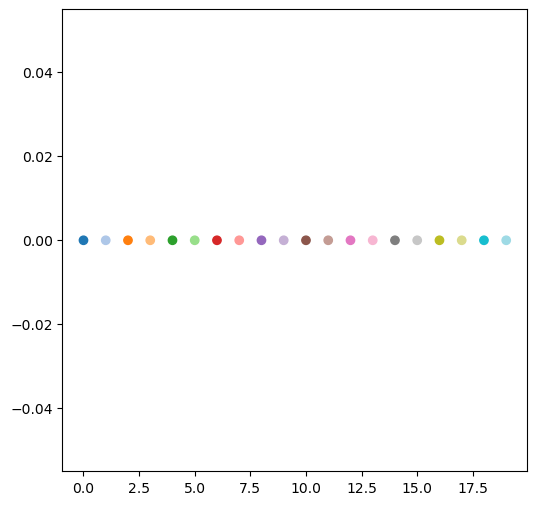

In [205]:
fig, ax = plt.subplots(figsize=(6, 6))

colors_ = [plt.cm.tab20(i) for i in np.arange(20)]
ax.scatter(np.arange(20), np.zeros(20), c=colors_)
plt.show()

[0.82607805 0.83625958 0.71367353 0.52946431 0.23794408 0.16728302] [0.65051551 0.71279962 0.64949248 0.89875119 0.21808345 0.10220514]


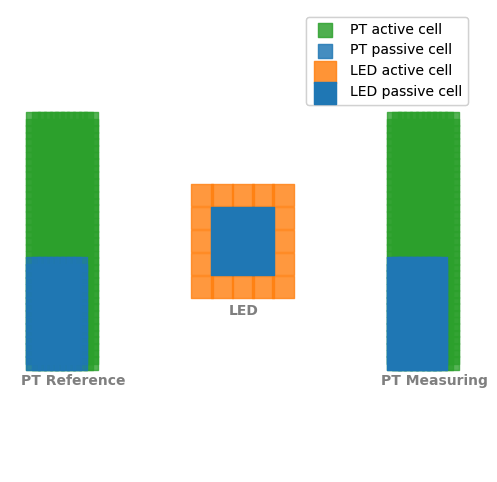

In [275]:
# Создаем график

# csfont = {'fontname':'Times New Roman'}
plt.rcParams["font.family"] = "Times New Roman"

fig, ax = plt.subplots(figsize=(6, 6))

labels_colors = [plt.cm.tab20(4), plt.cm.tab20(0), plt.cm.tab20(2) , plt.cm.tab20(0)]
scatter_list = []
scatter_labels = []
edge_color = "#000001"
text_color = plt.cm.tab20(14)
labels = ["PT active cell", "PT passive cell", "LED active cell", "LED passive cell"]
colors = ["red", "black", "red", "black", "orange", "indigo"]
map_list = {
    "PT reference": 0,
    "PT reference passive cell": 1,
    "PT cell": 0,
    "PT passive cell": 1,
    "LED cell": 2,
    "LED passive cell": 3,
}
scatter_list = [0]*len(labels)

# Визуализируем матрицу 1
for i in range(PT_matrix_ref.shape[0]):
    for j in range(PT_matrix_ref.shape[1]):
        x, y = PT_matrix_ref[i][j]
        scatter_list[0] = ax.scatter(
            x,
            y,
            color=labels_colors[map_list["PT reference"]],
            marker="s",
            s=100,
            edgecolors=labels_colors[map_list["PT reference"]] ,
            alpha=0.8,
            
            # edgecolors="black",
            label="PT reference",
        )
# Визуализируем матрицу 1
for i in range(PT_matrix_ref.shape[0]):
    for j in range(PT_matrix_ref.shape[1]):
        x, y = PT_matrix_ref[i][j]
        if pt_blindness[i, j] == 0:
            scatter_list[1] = ax.scatter(
                x,
                y,
                color=labels_colors[map_list["PT reference passive cell"]],
                marker="s",
                s=100,
                alpha=0.8,
                
                edgecolors=labels_colors[map_list["PT reference passive cell"]] ,

                label="PT reference passive cell",
            )

# Визуализируем матрицу 1
for i in range(PT_matrix.shape[0]):
    for j in range(PT_matrix.shape[1]):
        x, y = PT_matrix[i][j]
        ax.scatter(
            x,
            y,
            color=labels_colors[map_list["PT cell"]],
            marker="s",
            s=100,
            edgecolors=labels_colors[map_list["PT cell"]] ,
            alpha=0.8,
            # edgecolors="black",
            label="PT cell",
        )
for i in range(PT_matrix.shape[0]):
    for j in range(PT_matrix.shape[1]):
        x, y = PT_matrix[i][j]
        if pt_blindness[i, j] == 0:
            ax.scatter(
                x, y, color=labels_colors[map_list["PT passive cell"]], 
                marker="s", 
                s=100, 
                edgecolors=labels_colors[map_list["PT passive cell"]] ,
                label="PT passive cell"
            )

# Визуализируем матрицу 2
for i in range(LED_matrix.shape[0]):
    for j in range(LED_matrix.shape[1]):
        x, y = LED_matrix[i][j]
        scatter_list[2] = ax.scatter(
            x,
            y,
            color=labels_colors[map_list["LED cell"]],
            marker="s",
            s=250,
            alpha=0.8,
        
            edgecolors=labels_colors[map_list["LED cell"]] ,
            # alpha=0.8,
            # edgecolors="black",
            label="LED cell",
        )
for i in range(LED_matrix.shape[0]):
    for j in range(LED_matrix.shape[1]):
        x, y = LED_matrix[i][j]
        if LED_blindness_matrix[i, j] == 0:
            scatter_list[3] = ax.scatter(
                x,
                y,
                color=labels_colors[map_list["LED passive cell"]],
                marker="s",
                s=250,
                # alpha=0.8,
                edgecolors=labels_colors[map_list["LED passive cell"]] ,
                
                label="LED passive cell",
            )



x, y = np.random.rand(2, len(colors))

print(x, y)

legend1 = ax.legend(scatter_list, labels, loc='upper right')

ax.annotate("PT Reference", xy=(PT_matrix_ref[0][int(n_pt_columns/2)]), color=text_color, 
            xytext=(-30,-16), textcoords="offset points", weight='bold',)

ax.annotate("PT Measuring", xy=(PT_matrix[0][int(n_pt_columns/2)]), color=text_color, 
            xytext=(-30,-16), textcoords="offset points", weight='bold',)

ax.annotate("LED", xy=(LED_matrix[0][int(n_columns/2)]), color=text_color, 
            xytext=(-10,-20), textcoords="offset points", weight='bold',)


ax.add_artist(legend1)

ax.set_axis_off()
ax.set_xlim((-0.8, 0.8))
ax.set_ylim((-0.7, 0.7))

# Отображаем график
plt.show()

In [87]:
scatter_list

In [152]:

# # Создаем график
# fig, ax = plt.subplots(figsize=(6,6))

# labels_colors = ['red', 'orange', 'black', 'indigo']
# # Визуализируем матрицу 1
# for i in range(PT_matrix_ref.shape[0]):
#     for j in range(PT_matrix_ref.shape[1]):
#         x, y = PT_matrix_ref[i][j]
#         scatter = ax.scatter(x, y, c=labels_colors[0],marker='s', s=100, edgecolors='black', label="PT reference")
#         if pt_blindness[i, j] == 0:
#             ax.scatter(x, y, c=labels_colors[2], marker='s', s=100, label="PT reference passive cell")
    

# # Визуализируем матрицу 1
# for i in range(PT_matrix.shape[0]):
#     for j in range(PT_matrix.shape[1]):
#         x, y = PT_matrix[i][j]
#         ax.scatter(x, y, c=labels_colors[0],marker='s', s=100, edgecolors='black', label="PT cell")
#         if pt_blindness[i, j] == 0:
#             pt1 = ax.scatter(x, y, c=labels_colors[2], marker='s', s=100, label="PT passive cell")


# # Визуализируем матрицу 2
# for i in range(LED_matrix.shape[0]):
#     for j in range(LED_matrix.shape[1]):
#         x, y = LED_matrix[i][j]
#         im= ax.scatter(x, y, c=labels_colors[1], marker='s', s=300, edgecolors='black', label='LED cell')
#         if LED_blindness_matrix[i, j] == 0:
#             ax.scatter(x, y, c=labels_colors[3],marker='s', s=300, alpha=0.8, edgecolors='black', label="LED passive cell")

# ax.set_xlim((-0.7, 0.7))
# ax.set_ylim((-0.7, 0.7))

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# # plt.legend()
# # ax.spines['bottom'].set_visible(False)
# # ax.spines['left'].set_visible(False)
# # Отображаем график
# plt.show()

## Intensity calculation

<img src="Radiation-intensity-with-distance.png" width=500>

$R = (x_l - x_p)^2 + (y_l - y_p)^2 + l_0 ^2$

$h = |y_p - y_l|$

$\theta = \arccos(\frac{h}{\sqrt{R}})$

$I = I_0 * \frac{l_0 \sin{\theta}}{2 \pi R}$

In [14]:
def calc_intensity(emitter_xy: [float, float],  receiver_xy: [float, float], l_0: float=3.5, I_0: float = 1.0):
    x_l, y_l = emitter_xy
    x_p, y_p = receiver_xy

    R_2 = (x_l - x_p)**2 + (y_l - y_p)**2 + l_0**2
    h = y_p - y_l
    h = h*np.sign(h)
    theta = np.arccos(h/np.sqrt(R_2))
    # from my calculations
    # return I_0*(np.sin(theta)**2)/(4*np.pi*R_2)
    
    # From the paper
    return I_0*(np.sin(theta))/(4*np.pi*R_2/(2*l_0))


def calc_intensity_matrix_to_point(pt_xy: [float, float], led_matrix, led_map=None, l_0: float=3.5, I_0: float = 1.0, y_max: float = None):

    if led_map is None:
        led_map = np.ones(shape=(led_matrix.shape[0], led_matrix.shape[1]))
    
    intensity = 0
    for i in range(led_matrix.shape[0]):
        for j in range(led_matrix.shape[1]):
            x, y = led_matrix[i, j]
            # print(y_max is None, y > y_max)
            if y_max is None or y < y_max:
                intensity+=calc_intensity(emitter_xy=led_matrix[i, j], receiver_xy=pt_xy) * led_map[i, j]
    return intensity

In [15]:
# intensity without blindness areas
PT_intensity_full_led = np.zeros(shape=(38, 11))

for i in range(PT_matrix.shape[0]):
    for j in range(PT_matrix.shape[1]):
        if pt_blind_x>i or pt_blind_y > j:
            PT_intensity_full_led[i, j] =  calc_intensity_matrix_to_point(PT_matrix[i, j],LED_matrix, led_map=None, l_0=-1, I_0=0)

In [16]:
# intensity with LED blindness areas
PT_intensity = np.zeros(shape=(38, 11))

for i in range(PT_matrix.shape[0]):
    for j in range(PT_matrix.shape[1]):
        if pt_blind_x>i or pt_blind_y > j:
            PT_intensity[i, j] =  calc_intensity_matrix_to_point(PT_matrix[i, j],LED_matrix, led_map=LED_blindness_matrix, l_0=-1, I_0=0)

In [17]:
# intensity with PT blindness areas
PT_intensity_blind = np.multiply(pt_blindness, PT_intensity_full_led)

# intensity with LED and PT blindness areas
PT_intensity_double_blind = pt_blindness * PT_intensity

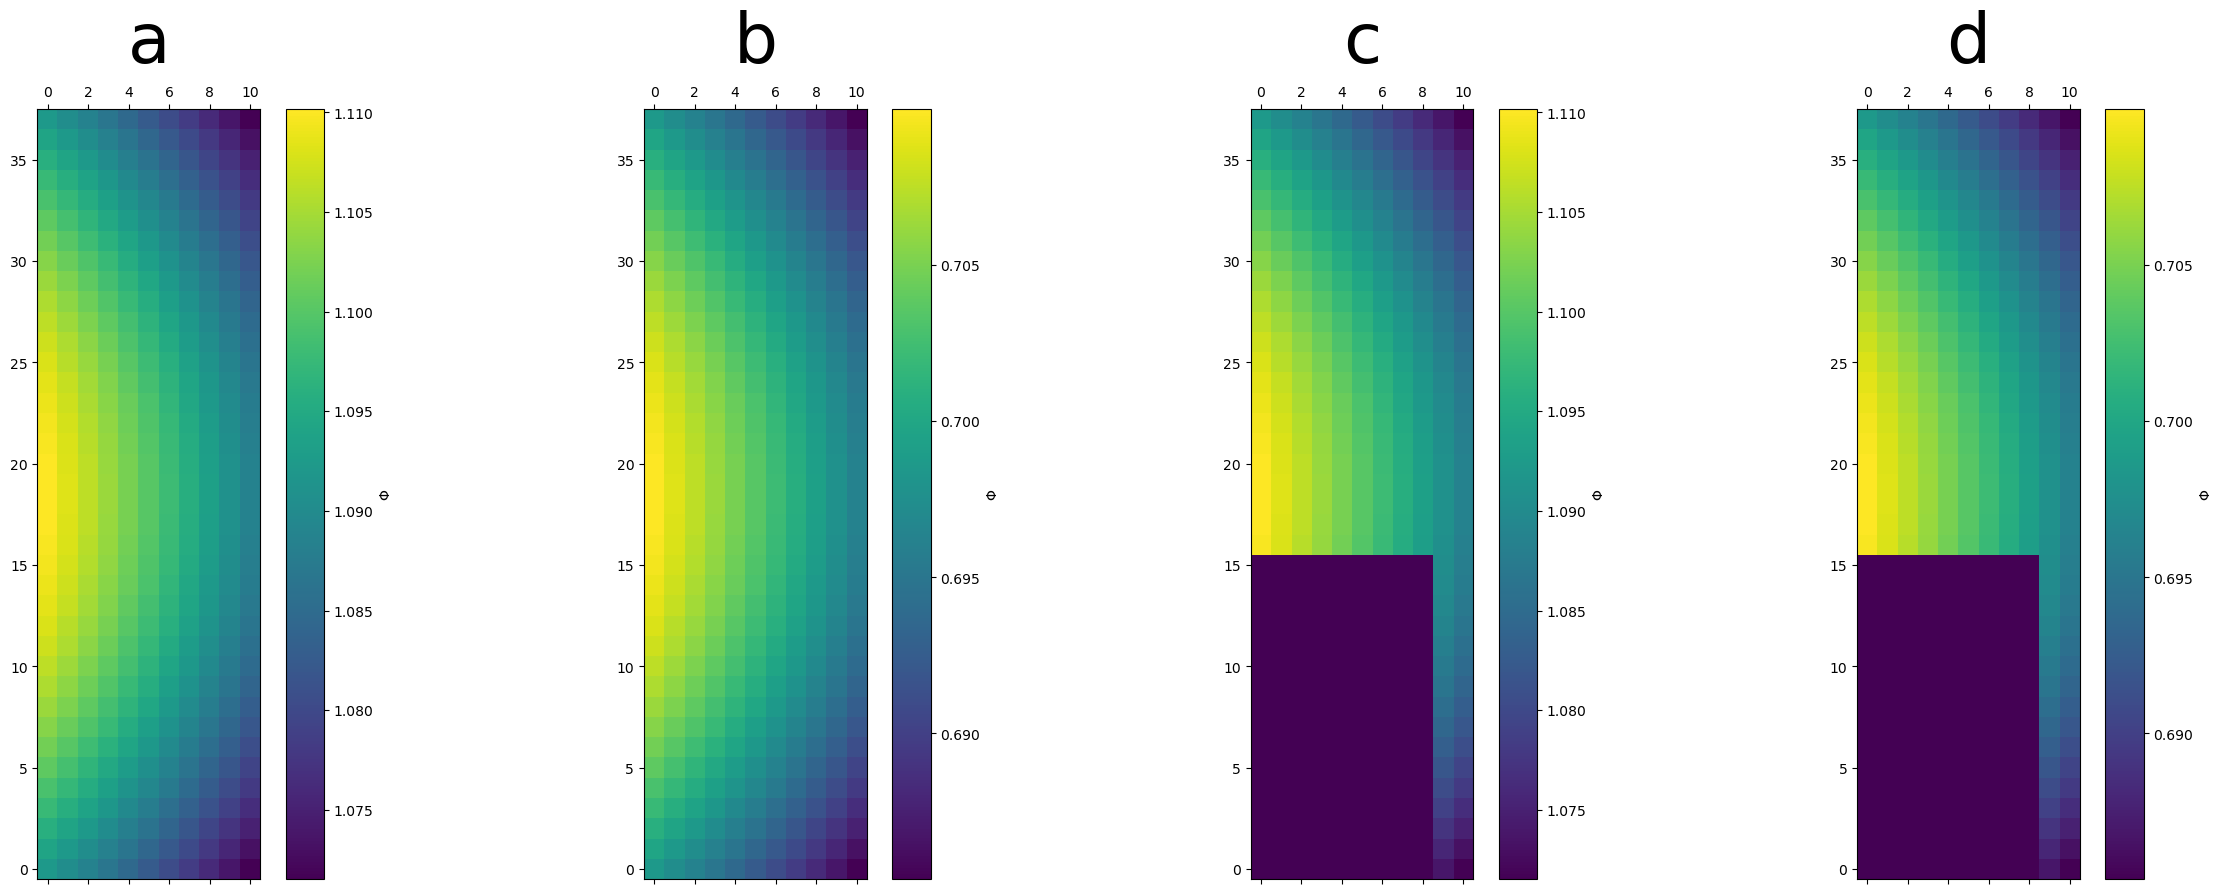

In [18]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(figsize=(30,10), ncols=4)


cax1 = axs[0].matshow(PT_intensity_full_led, interpolation='nearest', label='a')
cax2 = axs[1].matshow(PT_intensity, interpolation='nearest', label='b')
cax3 = axs[2].matshow(PT_intensity_blind, vmin=np.min(PT_intensity_full_led), label='c')
cax4 = axs[3].matshow(PT_intensity_double_blind, interpolation='nearest', vmin=np.min(PT_intensity), label='d')

labels = 'a', 'b', 'c', 'd'

for ax, label in zip(axs, labels):
    ax.set_title(label, fontsize = 50)

fig.colorbar(cax1, ax=axs[0], label='$\Phi$')
fig.colorbar(cax2, ax=axs[1], label='$\Phi$')
fig.colorbar(cax3, ax=axs[2], label='$\Phi$')
fig.colorbar(cax4, ax=axs[3], label='$\Phi$')
axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

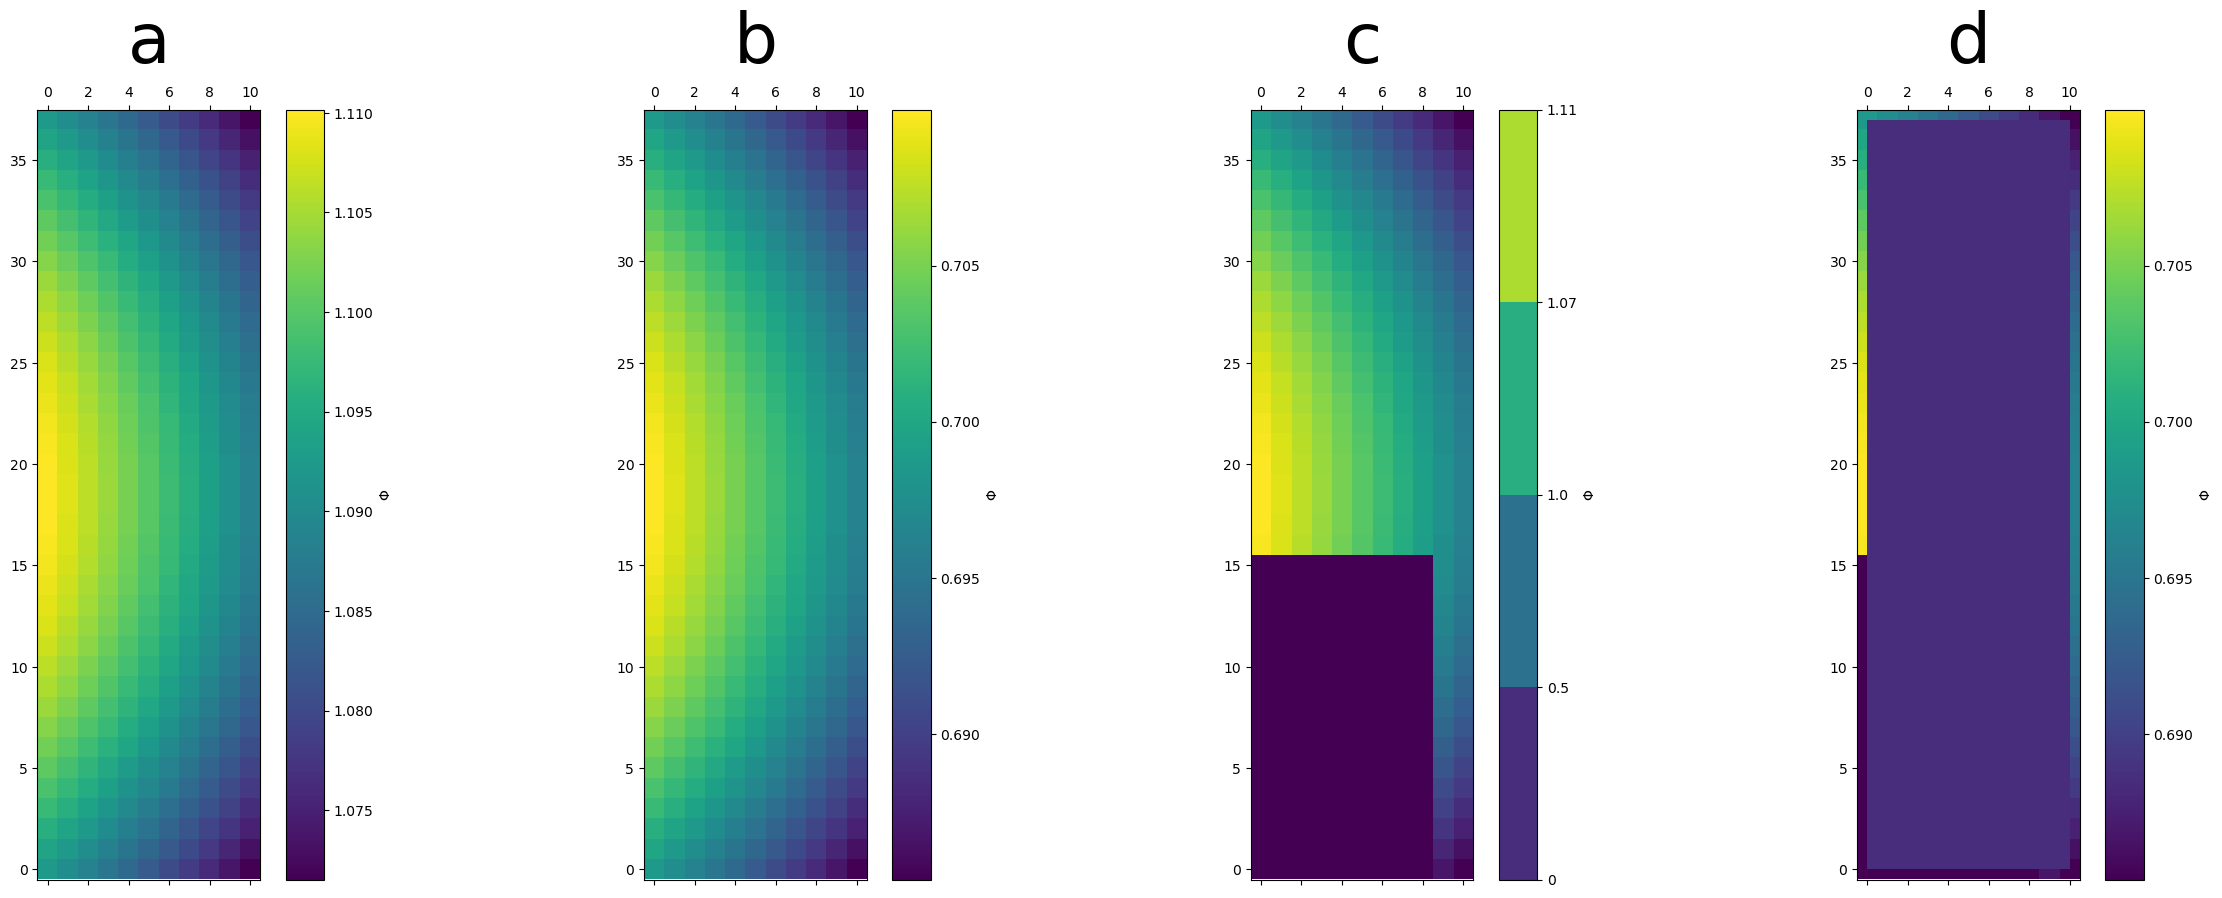

In [19]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter



fig, axs = plt.subplots(figsize=(30,10), ncols=4)

cax1 = axs[0].matshow(PT_intensity_full_led, interpolation='nearest', label='a')
cax2 = axs[1].matshow(PT_intensity, interpolation='nearest', label='b')
# cax3 = axs[2].matshow(PT_intensity_blind, interpolation='nearest',label='c')
cax3 = axs[2].matshow(PT_intensity_blind, vmin=np.min(PT_intensity_full_led), label='c')
cax4 = axs[3].matshow(PT_intensity_double_blind, interpolation='nearest', vmin=np.min(PT_intensity), label='d')

labels = 'a', 'b', 'c', 'd'



cf = plt.contourf(PT_intensity_blind, levels=(0, 2.5, 5, 7.5, 10))

fig.colorbar(cax1, ax=axs[0], label='$\Phi$')
fig.colorbar(cax2, ax=axs[1], label='$\Phi$')
cb = fig.colorbar(cf, ax=axs[2], label='$\Phi$')
cb.set_ticklabels([0, 0.5, 1.00, round(np.min(PT_intensity_full_led), 2),round(np.max(PT_intensity_full_led), 2)])
fig.colorbar(cax4, ax=axs[3], label='$\Phi$')
cb.formatter('%.2f')
for ax, label in zip(axs, labels):
    ax.set_title(label, fontsize = 50)
    labels = [item.get_text() for item in ax.get_xticklabels()]
    # Beat them into submission and set them back again
    # ax.set_xticklabels([str(round(float(label), 2)) for label in labels])
    # ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

In [20]:
dx, dy =  LED_matrix[1][1] - LED_matrix[0][0] 
dx, dy

(0.06999999999999998, 0.06999999999999998)

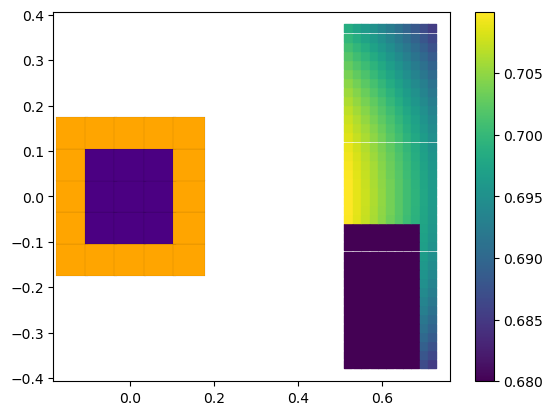

In [21]:

# Создаем график
fig, ax = plt.subplots()

# Визуализируем матрицу 1
for i in range(PT_matrix.shape[0]):
    for j in range(PT_matrix.shape[1]):
        x, y = PT_matrix[i][j]
        im =ax.scatter(x, y, c=PT_intensity_double_blind[i, j],  marker='s', vmin=0.68, vmax=np.max(PT_intensity_double_blind))
fig.colorbar(im, ax=ax)
        # if pt_blindness[i, j] == 0:
            # ax.scatter(x, y, c='black', s=100)

# Визуализируем матрицу 2
for i in range(LED_matrix.shape[0]):
    for j in range(LED_matrix.shape[1]):
        x, y = LED_matrix[i][j]
        im= ax.scatter(x, y, c='orange', marker='s', s=500, edgecolors='black', linewidths=0.05)
        if LED_blindness_matrix[i, j] == 0:
            ax.scatter(x, y, c='indigo',marker='s', s=500, edgecolors='black', linewidths=0.05)
# Настраиваем оси
# ax.set_xlim([int(np.min(np.min(PT_matrix[:, :, 0], np.min(LED_matrix[:, :, 0])))), int(np.max(np.max(PT_matrix[:, :, 0], np.max(LED_matrix[:, :, 0]))))])
# ax.set_ylim([np.min(np.min(PT_matrix[:, :, 1], np.min(LED_matrix[:, :, 1]))), np.max(np.max(PT_matrix[:, :, 1], np.max(LED_matrix[:, :, 1])))])

# Отображаем график
plt.show()

# Calculation with integration

In [22]:
# def opts_
from scipy import integrate
import numpy as np

# use casadi

def calc_intensity_integration(emitter_x: float, emitter_y: float,  receiver_x: float, receiver_y: float, l_0: float=3.5, I_0: float = 1.0):
    x_l, y_l = emitter_x, emitter_y
    x_p, y_p = receiver_x, receiver_y

    R_2 = (x_l - x_p)**2 + (y_l - y_p)**2 + l_0**2
    h = y_p - y_l
    h = h*np.sign(h)
    theta = np.arccos(h/np.sqrt(R_2))
    # from my calculations
    # return I_0*(np.sin(theta)**2)/(4*np.pi*R_2)
    # From the paper
    return I_0*(np.sin(theta))/(4*np.pi*R_2/(2*l_0))

def calc_flux_on_area(source_matrix, receiver_xy, dx, dy):
    x, y = receiver_xy
    lims = [[-S1/2, S1/2], [-S2/2, S2/2], [x-dx/2, x+dx/2], [y-dy/2, y+dy/2]]

    # for i in range(source_matrix.shape[0]):
    #     for j in range(source_matrix.shape[1]):
    #         print(source_matrix[i, j], receiver_xy)
    return integrate.nquad(calc_intensity_integration, ranges=lims)
    

In [23]:
# # def calc_flux(intensity_matrix, dx: float, dy: float):
# from tqdm import tqdm

# flux = np.zeros_like(PT_intensity)
# pbar = tqdm(total=PT_matrix.shape[0]*PT_matrix.shape[1])

# dx, dy =  PT_matrix[1, 1, :] - PT_matrix[0, 0, :] 
# # print(dx, dy)
# for i in tqdm(range(PT_matrix.shape[0])):
#     for j in range(PT_matrix.shape[1]):
#         result = calc_flux_on_area(LED_matrix, PT_matrix[i, j], dx, dy)
#         flux[i, j] = result[0]
#         pbar.update(1)

In [24]:

# fig, ax = plt.subplots(figsize=(30,10))

# cax = ax.matshow(flux, interpolation='nearest')
# fig.colorbar(cax, ax=ax)
# ax.invert_yaxis()

# Calculation of barrier

In [25]:
def calc_angle_to_barrier_tip(pt_xy: [float, float], led_matrix: np.ndarray, barrier_y_pos:float, y_led_to_bar: float=1.75, y_led_to_pt: float=3.5, led_map=None, I_0: float = 1.0):
    if led_map is None:
        led_map = np.ones(shape=(led_matrix.shape[0], led_matrix.shape[1]))
    
    pt_pos = np.array([pt_xy[0], pt_xy[1], y_led_to_pt])
    bar_pos = np.array([0, 0, y_led_to_bar])
    bar_pos_norm = y_led_to_bar
    
    intensity = 0
    for i in range(led_matrix.shape[0]):
        for j in range(led_matrix.shape[1]):
            led_pos = np.array([led_matrix[i, j][0], led_matrix[i, j][1], 0])
            cos_theta = bar_pos*led_pos/(bar_pos_norm*np.linalg.norm(led_pos))
            

In [48]:
# PT_matrix[:, 1][:, 1]
# PT_matrix
ld_ys = LED_matrix[:, 1][:, 1]
print(ld_ys)

[-1.40000000e-01 -7.00000000e-02 -2.77555756e-17  7.00000000e-02
  1.40000000e-01]


In [27]:
# pt_ys = PT_matrix[1, :][:, 0]
pt_ys = PT_matrix[:, 1][:, 1]
print(pt_ys)

[-0.37 -0.35 -0.33 -0.31 -0.29 -0.27 -0.25 -0.23 -0.21 -0.19 -0.17 -0.15
 -0.13 -0.11 -0.09 -0.07 -0.05 -0.03 -0.01  0.01  0.03  0.05  0.07  0.09
  0.11  0.13  0.15  0.17  0.19  0.21  0.23  0.25  0.27  0.29  0.31  0.33
  0.35  0.37]


In [63]:
# # Current height if the barrier lower edge
# y_barrier = 0.05
# # Depth of the barrier (along Z axis)
# barrier_depth = 0.01
# # Z position of the barrier (along the axis of direct light)
# z_barrier = l0 / 2

# # find extreme y coordinates of light emitter for each PT cell
# extreme_ys_led = np.zeros_like(pt_ys)
# for i, extreme_y in enumerate(extreme_ys_led):
#     dy = pt_ys[i] - y_barrier
#     dz = 0
#     if pt_ys[i] > y_barrier:
#         dz = (l0 - z_barrier) - barrier_depth/2
#     else:
#         dy = np.sign(dy)
#         dz = (l0 - z_barrier) + barrier_depth/2

#     extreme_ys_led[i] = l0 * dy / dz

# len(extreme_ys_led), len(pt_ys), ld_ys

In [288]:
# Current height if the barrier lower edge
y_barrier = 0.25
# Depth of the barrier (along Z axis)
barrier_depth = 0.01
# Z position of the barrier (along the axis of direct light)
z_barrier = l0 / 2
extreme_ys = np.zeros_like(pt_ys)

for i, extreme_y in enumerate(extreme_ys):
    y_pt = pt_ys[i]

    dy = y_barrier - y_pt
    dz = z_barrier
    if (y_pt > y_barrier):
        dz += (barrier_depth / 2)
    else:
        dz -= (barrier_depth / 2)

    # dz += (barrier_depth / 2) * (-1) ** (y_pt > y_barrier)

    extreme_ys[i] = dy * l0 / dz
    
extreme_ys

array([ 1.24355301e+00,  1.20343840e+00,  1.16332378e+00,  1.12320917e+00,
        1.08309456e+00,  1.04297994e+00,  1.00286533e+00,  9.62750716e-01,
        9.22636103e-01,  8.82521490e-01,  8.42406877e-01,  8.02292264e-01,
        7.62177650e-01,  7.22063037e-01,  6.81948424e-01,  6.41833811e-01,
        6.01719198e-01,  5.61604585e-01,  5.21489971e-01,  4.81375358e-01,
        4.41260745e-01,  4.01146132e-01,  3.61031519e-01,  3.20916905e-01,
        2.80802292e-01,  2.40687679e-01,  2.00573066e-01,  1.60458453e-01,
        1.20343840e-01,  8.02292264e-02,  4.01146132e-02,  2.22680836e-16,
       -3.98860399e-02, -7.97720798e-02, -1.19658120e-01, -1.59544160e-01,
       -1.99430199e-01, -2.39316239e-01])

In [289]:
PT_matrix[0]

array([[ 0.52, -0.37],
       [ 0.54, -0.37],
       [ 0.56, -0.37],
       [ 0.58, -0.37],
       [ 0.6 , -0.37],
       [ 0.62, -0.37],
       [ 0.64, -0.37],
       [ 0.66, -0.37],
       [ 0.68, -0.37],
       [ 0.7 , -0.37],
       [ 0.72, -0.37]])

In [290]:
# PT_intensity_barr = np.full(shape=pt_blindness.shape, fill_value=100000, dtype=np.float64)
PT_intensity_barr = np.zeros_like(pt_blindness)

# k = 0
for i in range(PT_matrix.shape[0]):
    # k +=1
    for j in range(PT_matrix.shape[1]):
        if pt_blind_x > i or pt_blind_y > j:
            PT_intensity_barr[i, j] = calc_intensity_matrix_to_point(
                PT_matrix[i, j],
                LED_matrix,
                led_map=LED_blindness_matrix,
                l_0=l0,
                I_0=1,
                y_max=extreme_ys[i],
            )
# k

In [291]:
np.max(PT_intensity - PT_intensity_barr), np.max(PT_intensity_barr)

(0.7009102736849039, 0.7099994534621694)

In [292]:
# from matplotlib.collections import PatchCollection
# from matplotlib.patches import Rectangle

# # Создаем график
# fig, ax = plt.subplots()

# # Визуализируем приемник света
# for i in range(PT_matrix.shape[0]):
#     for j in range(PT_matrix.shape[1]):
#         x, y = PT_matrix[i][j]
#         im = ax.scatter(
#             x,
#             y,
#             c=0 if pt_blindness[i, j] == 0 else PT_intensity_barr[i, j],
#             marker="s",
#             edgecolors='black',
#             vmin=np.min(PT_intensity_barr),
#             vmax=np.max(PT_intensity_barr),
#         )


# xy = 0, y_barrier
# height = Y/2 - y_barrier
# width = 0.8

# ax.add_patch(Rectangle(xy, width=width, height=height, alpha=0.3))
# fig.colorbar(im, ax=ax)

# # Визуализируем источник света
# for i in range(LED_matrix.shape[0]):
#     for j in range(LED_matrix.shape[1]):
#         x, y = LED_matrix[i][j]
#         im = ax.scatter(
#             x, y, c="orange", marker="s", s=500, edgecolors="black", linewidths=0.05
#         )
#         if LED_blindness_matrix[i, j] == 0:
#             ax.scatter(
#                 x, y, c="indigo", marker="s", s=500, edgecolors="black", linewidths=0.05
#             )

# # # Настраиваем оси
# # ax.set_xlim([int(np.min(np.min(PT_matrix[:, :, 0], np.min(LED_matrix[:, :, 0])))), int(np.max(np.max(PT_matrix[:, :, 0], np.max(LED_matrix[:, :, 0]))))])
# # ax.set_ylim([np.min(np.min(PT_matrix[:, :, 1], np.min(LED_matrix[:, :, 1]))), np.max(np.max(PT_matrix[:, :, 1], np.max(LED_matrix[:, :, 1])))])

# plt.tick_params(left = False, bottom=False, labelleft = False, labelbottom = False) 

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# # Отображаем график
# plt.show()

/tmp/ipykernel_517924/3226787584.py:153: UserWarning: set_ticks() must have been called.
  cb.set_ticklabels([0, 0.5, 1.00, round(np.min(PT_intensity_barr), 2),round(np.max(PT_intensity_barr), 2)])


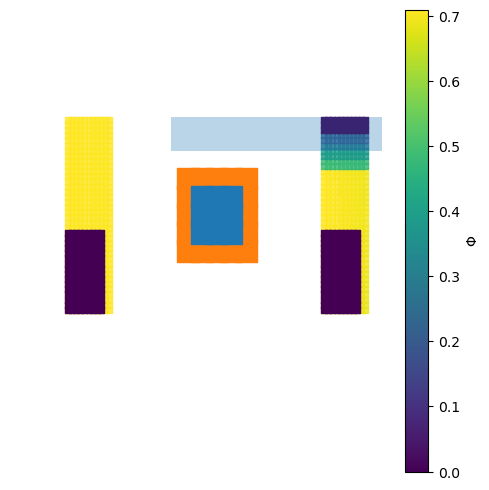

In [293]:
# Создаем график

# csfont = {'fontname':'Times New Roman'}
plt.rcParams["font.family"] = "Times New Roman"

fig, ax = plt.subplots(figsize=(6, 6))

labels_colors = [np.max(PT_intensity_barr), np.min(PT_intensity_barr), plt.cm.tab20(2) , plt.cm.tab20(0)]
scatter_list = []
scatter_labels = []
edge_color = "#000001"
text_color = plt.cm.tab20(14)
labels = ["PT active cell", "PT passive cell", "LED active cell", "LED passive cell"]
colors = ["red", "black", "red", "black", "orange", "indigo"]
map_list = {
    "PT reference": 0,
    "PT reference passive cell": 1,
    "PT cell": 0,
    "PT passive cell": 1,
    "LED cell": 2,
    "LED passive cell": 3,
}
scatter_list = [0]*len(labels)

# Визуализируем матрицу 1
for i in range(PT_matrix_ref.shape[0]):
    for j in range(PT_matrix_ref.shape[1]):
        x, y = PT_matrix_ref[i][j]
        scatter_list[0] = ax.scatter(
            x,
            y,
            c=labels_colors[map_list["PT reference"]],
            marker="s",
            s=25,
            # edgecolors=labels_colors[map_list["PT reference"]] ,
            alpha=0.8,
            
            # edgecolors="black",
            label="PT reference",
            vmin=np.min(PT_intensity_barr),
            vmax=np.max(PT_intensity_barr),
        )
        
for i in range(PT_matrix_ref.shape[0]):
    for j in range(PT_matrix_ref.shape[1]):
        x, y = PT_matrix_ref[i][j]
        if pt_blindness[i, j] == 0:
            scatter_list[1] = ax.scatter(
                x,
                y,
                c=labels_colors[map_list["PT reference passive cell"]],
                marker="s",
                s=25,
                # edgecolors="black",
                
                alpha=1,
                
                # edgecolors=labels_colors[map_list["PT reference passive cell"]] ,

                label="PT reference passive cell",
                
            )

# Визуализируем матрицу 1
for i in range(PT_matrix.shape[0]):
    for j in range(PT_matrix.shape[1]):
        x, y = PT_matrix[i][j]
        im = ax.scatter(
            x,
            y,
            c=PT_intensity_barr[i, j],
            marker="s",
            s=25,
            alpha=1 if PT_intensity_barr[i, j] == 0 else 0.8,
            
            # edgecolors='black',
            vmin=np.min(PT_intensity_barr),
            vmax=np.max(PT_intensity_barr),
        )
for i in range(PT_matrix.shape[0]):
    for j in range(PT_matrix.shape[1]):
        x, y = PT_matrix[i][j]
        if pt_blindness[i, j] == 0:
            im = ax.scatter(
            x,
            y,
            c=0,
            marker="s",
            s=25,
            # alpha=0.8 if PT_intensity_barr[i, j] + pt_blindness[i, j] == 0 else 1,
            
            # edgecolors='black',
            vmin=np.min(PT_intensity_barr),
            vmax=np.max(PT_intensity_barr),
        )
        
# Визуализируем матрицу 2
for i in range(LED_matrix.shape[0]):
    for j in range(LED_matrix.shape[1]):
        x, y = LED_matrix[i][j]
        scatter_list[2] = ax.scatter(
            x,
            y,
            color=labels_colors[map_list["LED cell"]],
            marker="s",
            s=250,
            # alpha=1,
        
            edgecolors=labels_colors[map_list["LED cell"]] ,
            # alpha=0.8,
            # edgecolors="black",
            label="LED cell",
        )
for i in range(LED_matrix.shape[0]):
    for j in range(LED_matrix.shape[1]):
        x, y = LED_matrix[i][j]
        if LED_blindness_matrix[i, j] == 0:
            scatter_list[3] = ax.scatter(
                x,
                y,
                color=labels_colors[map_list["LED passive cell"]],
                marker="s",
                s=250,
                # alpha=0.8,
                edgecolors=labels_colors[map_list["LED passive cell"]] ,
                
                label="LED passive cell",
            )


# x, y = np.random.rand(2, len(colors))

# print(x, y)

# legend1 = ax.legend(scatter_list, labels, loc='upper right')

# ax.annotate("PT Reference", xy=(PT_matrix_ref[0][int(n_pt_columns/2)]), color=text_color, 
#             xytext=(-30,-16), textcoords="offset points", weight='bold',)

# ax.annotate("PT Measuring", xy=(PT_matrix[0][int(n_pt_columns/2)]), color=text_color, 
#             xytext=(-30,-16), textcoords="offset points", weight='bold',)

# ax.annotate("LED", xy=(LED_matrix[0][int(n_columns/2)]), color=text_color, 
#             xytext=(-10,-20), textcoords="offset points", weight='bold',)

xy = -X, y_barrier
height = Y/2 - y_barrier
width = X + 0.8

ax.add_patch(Rectangle(xy, width=width, height=height, alpha=0.3))
# cf = plt.contourf(PT_intensity_barr, levels=(0, 2.5, 5, 7.5, 10))
cb = fig.colorbar(im, ax=ax, label='$\Phi$')
cb.set_ticklabels([0, 0.5, 1.00, round(np.min(PT_intensity_barr), 2),round(np.max(PT_intensity_barr), 2)])


# fig.colorbar(im, ax=ax)

# ax.add_artist(legend1)

ax.set_axis_off()
ax.set_xlim((-1, 0.8))
ax.set_ylim((-1, 0.8))

# Отображаем график
plt.show()